In [1]:

import pandas as pd
import numpy as np

In [2]:

df = pd.read_csv('911.csv')

In [3]:

print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset Information:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())

First 5 rows of the dataset:
         lat        lng                                               desc  \
0  40.297876 -75.581294  REINDEER CT & DEAD END;  NEW HANOVER; Station ...   
1  40.258061 -75.264680  BRIAR PATH & WHITEMARSH LN;  HATFIELD TOWNSHIP...   
2  40.121182 -75.351975  HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...   
3  40.116153 -75.343513  AIRY ST & SWEDE ST;  NORRISTOWN; Station 308A;...   
4  40.251492 -75.603350  CHERRYWOOD CT & DEAD END;  LOWER POTTSGROVE; S...   

       zip                    title            timeStamp                twp  \
0  19525.0   EMS: BACK PAINS/INJURY  2015-12-10 17:10:52        NEW HANOVER   
1  19446.0  EMS: DIABETIC EMERGENCY  2015-12-10 17:29:21  HATFIELD TOWNSHIP   
2  19401.0      Fire: GAS-ODOR/LEAK  2015-12-10 14:39:21         NORRISTOWN   
3  19401.0   EMS: CARDIAC EMERGENCY  2015-12-10 16:47:36         NORRISTOWN   
4      NaN           EMS: DIZZINESS  2015-12-10 16:56:52   LOWER POTTSGROVE   

                         ad

In [4]:
df['Emergency_Type'] = df['title'].apply(lambda title: title.split(':')[0])


df['timeStamp'] = pd.to_datetime(df['timeStamp'])


df['Hour'] = df['timeStamp'].apply(lambda time: time.hour)
df['Month'] = df['timeStamp'].apply(lambda time: time.month)
df['Day of Week'] = df['timeStamp'].apply(lambda time: time.dayofweek)


dmap = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}

df['Day of Week'] = df['Day of Week'].map(dmap)

df['zip'] = df['zip'].fillna(df['zip'].mode()[0])
df['twp'] = df['twp'].fillna(df['twp'].mode()[0])


df.to_csv('cleaned_911_data.csv', index=False)

print("\nData cleaning and feature engineering complete. Cleaned data saved to 'cleaned_911_data.csv'")



Data cleaning and feature engineering complete. Cleaned data saved to 'cleaned_911_data.csv'


In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('emergency_response.db')
c = conn.cursor()

cleaned_df = pd.read_csv('cleaned_911_data.csv')

cleaned_df.to_sql('emergency_calls', conn, if_exists='replace', index=False)

conn.commit()
conn.close()

print("\nSuccess: The 'emergency_calls' table has been created in 'emergency_response.db'")


Success: The 'emergency_calls' table has been created in 'emergency_response.db'


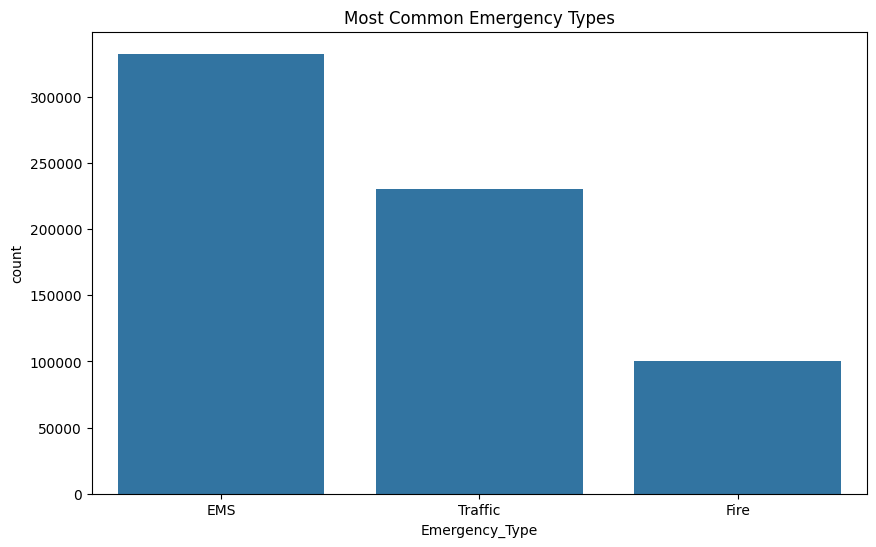

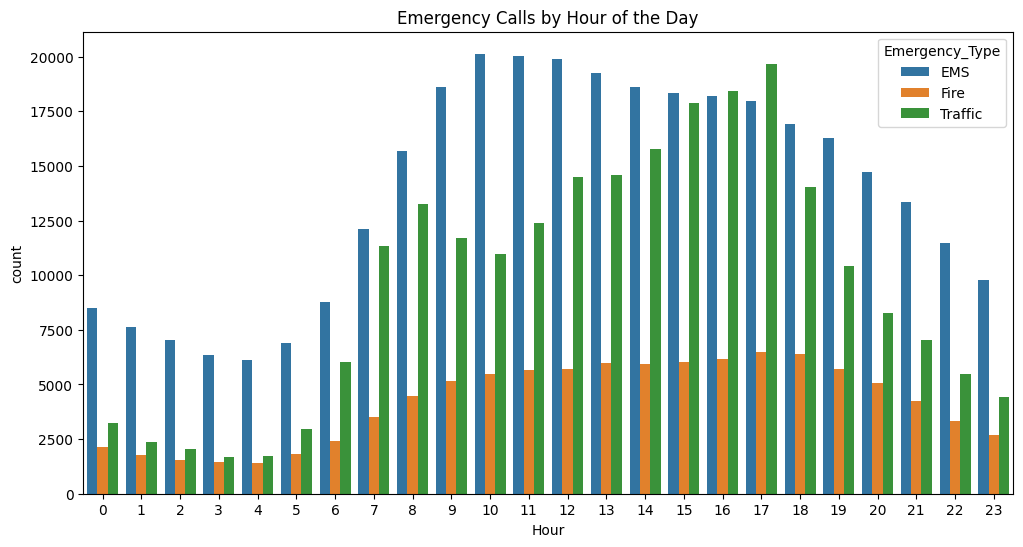


--- Model Evaluation (Random Forest with Feature Engineering) ---
              precision    recall  f1-score   support

         EMS       0.82      0.89      0.85      7474
        Fire       0.95      1.00      0.97      2241
     Traffic       0.82      0.70      0.76      5285

    accuracy                           0.84     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.84      0.84      0.84     15000



In [6]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report


conn = sqlite3.connect('emergency_response.db')
df = pd.read_sql_query("SELECT * from emergency_calls", conn)
conn.close()


plt.figure(figsize=(10,6))
sns.countplot(x='Emergency_Type', data=df, order = df['Emergency_Type'].value_counts().index)
plt.title('Most Common Emergency Types')
plt.show()


plt.figure(figsize=(12,6))
sns.countplot(x='Hour', data=df, hue='Emergency_Type')
plt.title('Emergency Calls by Hour of the Day')
plt.show()


df_model = df[df['Emergency_Type'].isin(['EMS', 'Traffic', 'Fire'])]


df_sample = df_model.sample(n=50000, random_state=101)


X = df_sample[['Hour', 'Month', 'Day of Week', 'lat', 'lng', 'title']].copy()
y = df_sample['Emergency_Type']



X['is_vehicle_accident'] = X['title'].str.contains('VEHICLE ACCIDENT', case=False).astype(int)
X['is_cardiac'] = X['title'].str.contains('CARDIAC', case=False).astype(int)
X['is_fire'] = X['title'].str.contains('FIRE', case=False).astype(int)
X['is_fall'] = X['title'].str.contains('FALL', case=False).astype(int)


X = X.drop('title', axis=1)


X = pd.get_dummies(X, columns=['Day of Week'], drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42) 
model.fit(X_train, y_train)


predictions = model.predict(X_test)
print("\n--- Model Evaluation (Random Forest with Feature Engineering) ---")
print(classification_report(y_test, predictions))

